## BBC Experiment [Part 6 - Multi Task fastai Data Loader]

- ok, I think this is the last piece of the puzzle. 

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['__version__', 'partition', 'subplots', 'copy', 'random', 'pad', 'uniform', 'array']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [7]:
path=Path('../data/bbc_train')

In [8]:
path.ls()

[PosixPath('../data/bbc_train/train.json'),
 PosixPath('../data/bbc_train/train_classification_labels.csv'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/train_masks'),
 PosixPath('../data/bbc_train/train')]

In [9]:
fnames = get_image_files(path/'train')
fnames[:3]

[PosixPath('../data/bbc_train/train/P2050886.jpg'),
 PosixPath('../data/bbc_train/train/P2050729.jpg'),
 PosixPath('../data/bbc_train/train/P2050513.jpg')]

In [10]:
lbl_names = get_image_files(path/'train_masks')
lbl_names[:3]

[PosixPath('../data/bbc_train/train_masks/P2050393.png'),
 PosixPath('../data/bbc_train/train_masks/P2050807.png'),
 PosixPath('../data/bbc_train/train_masks/P2050940.png')]

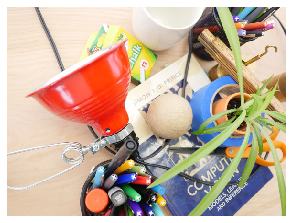

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [12]:
def get_y_fn(x): return path/'train_masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

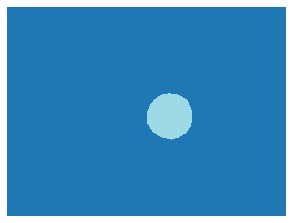

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
unique(mask.data)

array([0, 2])

In [15]:
src = (SegmentationItemList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [16]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [17]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Test: None

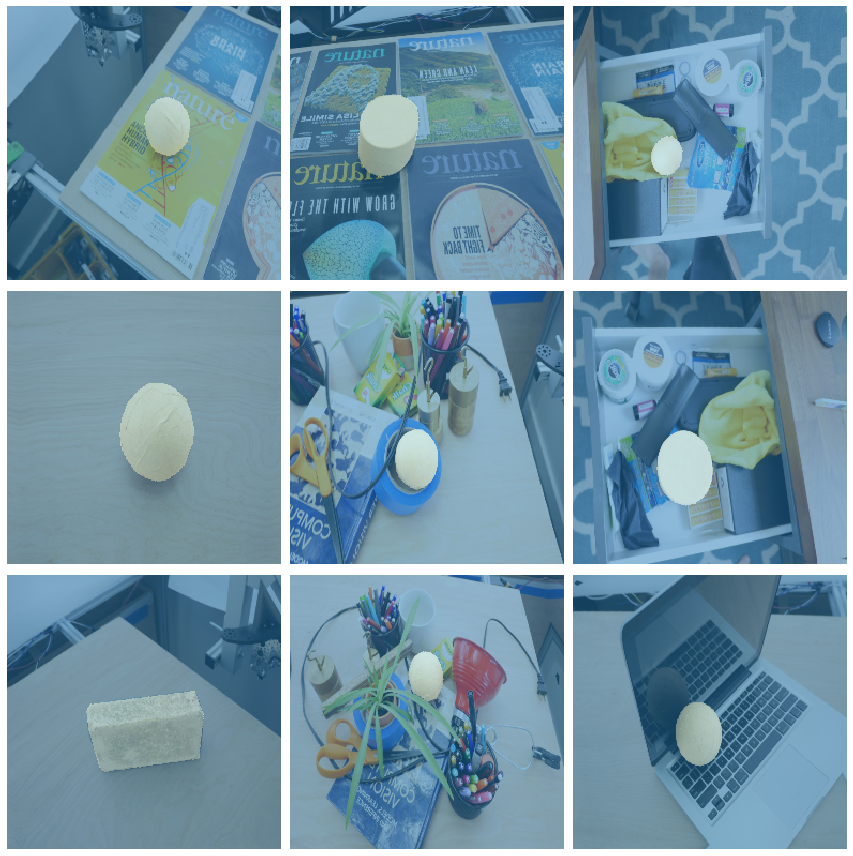

In [18]:
data.show_batch(3, figsize=(12,12))

In [110]:
x,y = data.one_batch()

In [111]:
x.shape, x.dtype, y.shape, y.dtype

(torch.Size([16, 3, 256, 256]),
 torch.float32,
 torch.Size([16, 1, 256, 256]),
 torch.int64)

In [112]:
np.unique(y)

array([0, 1, 2, 3])

In [113]:
#Extract class label from mask:
class_labels=torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(x.shape[0])])

#Extract bounding box from mask:
bboxes=torch.zeros(x.shape[0], 4)
for i in range(x.shape[0]):
    rows,cols=torch.where(y[i, 0]!=0)
    bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])

In [114]:
def blend_image_mask(im, mask, alpha=0.7):
    im_mask=np.zeros((im.shape[1], im.shape[2], 3), dtype='float32')
    for j in range(3): im_mask[:,:,j]=im.mean(axis=0)
    for j in range(1, 4):
        im_mask[mask==j] = alpha*im_mask[mask==j] + (1-alpha)*np.array([float(i==(j-1)) for i in range(3)])
    return im_mask

In [115]:
def corners_from_bbox(bbox):
    return np.array([[bbox[1], bbox[0]], 
                  [bbox[3], bbox[0]],
                  [bbox[3], bbox[2]],
                  [bbox[1], bbox[2]],
                  [bbox[1], bbox[0]]])

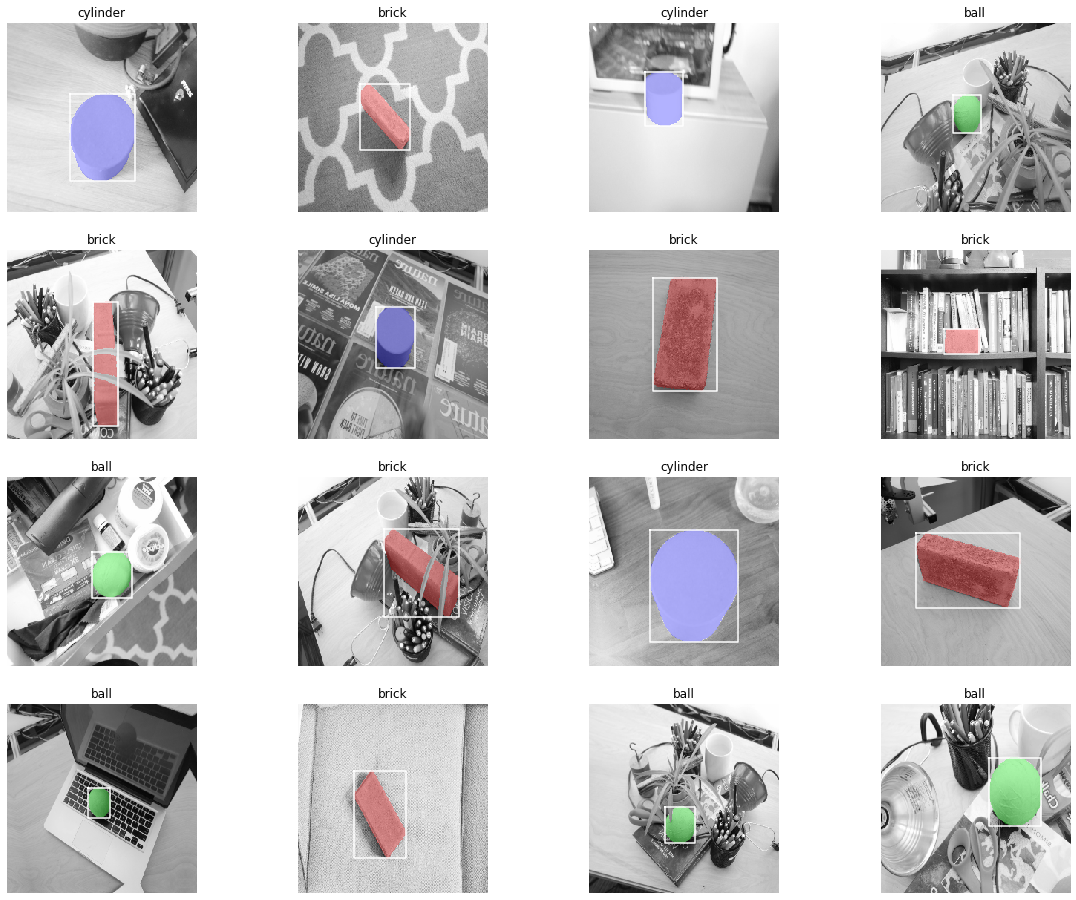

In [122]:
fig = figure(0, (20, 16))

for i in range(16):
    fig.add_subplot(4,4,i+1)
    im_mask=blend_image_mask(x[i], y[i, 0])
    corners=corners_from_bbox(bboxes[i, :])
    
    imshow(im_mask, cmap='gray'); axis('off')
    plot(corners[:, 0], corners[:,1], c=(1, 1, 1))
    title(data.classes[class_labels[i]])

- This would look cool in a video!!

In [118]:
data.classes[class_labels[i]]

'cylinder'

In [102]:
bbox

array([ 68,  98, 166, 167])

In [48]:
i=5
class_index=np.unique(y[i][y[i]!=0])[0]

In [52]:
y[i].shape

torch.Size([1, 256, 256])

In [67]:
rows, cols = np.where(y[i, 0]!=0)
bbox = np.array([rows.min(), cols.min(), rows.max(), cols.max()])

In [68]:
corners=np.array([[bbox[1], bbox[0]], 
                  [bbox[3], bbox[0]],
                  [bbox[3], bbox[2]],
                  [bbox[1], bbox[2]],
                  [bbox[1], bbox[0]]])

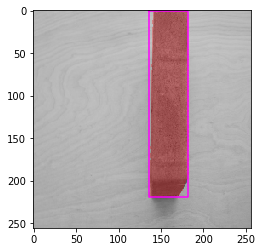

In [84]:
im_mask=blend_image_mask(x[i], y[i, 0])
imshow(im_mask, cmap='gray')
plot(corners[:, 0], corners[:,1], c=(1, 0, 1))